In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import sys 
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import glob
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../src')

In [3]:
from spaceoracle.prophets import Prophet
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.plotting.cartography import Cartography

In [4]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [5]:
extra = pd.read_csv('banksy_cluster.csv', index_col=0)
adata.obs = adata.obs.join(extra.banksy_cluster)
adata.obs['banksy_cluster'] = adata.obs['banksy_cluster'].astype('category')
adata.obsm['X_umap'] = extra[['0', '1']].values

In [6]:
adata.obs.banksy_cluster.value_counts()

banksy_cluster
0     5087
2     3936
4     3809
7     3478
9     2872
11    2094
13     765
15      63
17      51
20      46
22      26
Name: count, dtype: int64

In [7]:
# fig, axs = plt.subplots(2, 3, figsize=(15, 9), dpi=140)
# clusters = [0, 2, 4, 7, 9, 11]

# for i, cluster in enumerate(clusters):
#     row = i // 3
#     col = i % 3
#     sc.pl.embedding(adata, basis='spatial', color=['banksy_cluster'], 
#                    groups=[cluster], frameon=False, size=10, 
#                    ax=axs[row, col], show=False, 
#                    title=f'Cluster {cluster}')

# plt.tight_layout()
# plt.show()

In [8]:
files = glob.glob('/Volumes/SSD/lasso_runs/slideseq_mouse_lymphnode/*_betadata.parquet')

In [9]:
len(files)

1924

In [10]:
# from collections import defaultdict
# beta_records = defaultdict(list)

# for f in tqdm(files):
#     gene_name = f.split('/')[-1].replace('_betadata.parquet', '')
#     beta = pd.read_parquet(f)
#     beta = beta.join(adata.obs.cell_type).query('cell_type=="Th2"').drop(columns=['cell_type'])

#     for k, v in beta[[i for i in beta.columns if '$' in i]].mean().to_dict().items():
#         if abs(v) > 0:
#             beta_records[k].append((gene_name, v))

In [11]:
# interactions =pd.DataFrame([(k, gene, beta) for k, gene_beta_pairs in beta_records.items() for gene, beta in gene_beta_pairs], 
#              columns=['interaction', 'gene', 'beta'])

In [12]:
# interactions[['interaction', 'gene', 'beta']].copy()
# interactions['ligand'] = interactions['interaction'].str.split('_').str[1].str.split('$').str[0]
# interactions['receptor'] = interactions['interaction'].str.split('_').str[1].str.split('$').str[1]
# interactions = interactions[['ligand', 'receptor', 'gene', 'beta']]

In [13]:
# interactions.query('ligand=="Lgals9"').beta.sum()

In [14]:
# interactions.query('ligand.isin(["Lgals9"])').sort_values(by='beta', ascending=False, key=abs).head(20)

In [15]:
files = [i.split('/')[-1].split('_')[0] for i in glob.glob(
    '/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode/*.parquet')]

In [16]:
from tqdm.autonotebook import tqdm

In [17]:
from spaceoracle.tools.network import RegulatoryFactory
co_grn = RegulatoryFactory(
    colinks_path='/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode_colinks.pkl',
    annot='cell_type_int'
)

In [18]:
# ko_data = []

# for kotarget in tqdm(files):
#     data = pd.read_parquet(f'/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode/{kotarget}_4n_0x.parquet')
#     data = data.loc[adata.obs_names] - adata.to_df(layer='imputed_count')
#     data = data.join(adata.obs.cell_type).groupby('cell_type').mean().abs().mean(axis=1)

#     ds = {}
#     for k, v in data.sort_values(ascending=False).to_dict().items():
#         ds[k] = v

#     data = pd.DataFrame.from_dict(ds, orient='index')
#     data.columns = [kotarget]
#     ko_data.append(data)

In [19]:
# ko_concat = pd.concat(ko_data, axis=1)
# ko_concat.to_csv('ko_concat.csv')

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [20]:
ko_concat = pd.read_csv('ko_concat.csv', index_col=0)

In [21]:
ko_concat = ko_concat.drop('DC')

In [22]:
import commot as ct
from spaceoracle.tools.network import expand_paired_interactions
radius = 450
contact_distance = 50

df_ligrec = ct.pp.ligand_receptor_database(
    database='CellChat', 
    species='mouse', 
    signaling_type=None
) 

df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  

lr = expand_paired_interactions(df_ligrec)
lr = lr[lr.ligand.isin(adata.var_names) &\
    (lr.receptor.isin(adata.var_names))]
lr['radius'] = np.where(
    lr['signaling'] == 'Secreted Signaling', 
    radius, contact_distance
)

In [23]:
lr_pairs = ko_concat[np.intersect1d(
        lr.ligand.unique(), ko_concat.columns)
    ].mean(0).sort_values(ascending=False).head(10).index.to_list() + \
ko_concat[np.intersect1d(
        lr.receptor.unique(), ko_concat.columns)
    ].mean(0).sort_values(ascending=False).head(10).index.to_list()

In [24]:
counts_df = adata.to_df(layer='imputed_count')

In [25]:
results = []
for l, r in lr[(lr.ligand.isin(lr_pairs)) | (lr.receptor.isin(lr_pairs))][['ligand', 'receptor']].values:
    results.append((f'{l}-{r}', counts_df[l].mean(), counts_df[r].mean()))


In [26]:
dff = pd.DataFrame(results, columns=['interaction', 'ligand_mean', 'receptor_mean'])
dff['interaction_score'] = dff['ligand_mean'] * dff['receptor_mean']

In [27]:

color_dict = {
    'B': '#9e18f1',
    'Resting T': '#a5b146',
    'Tfh': '#1032ee',
    'CD8+ T': '#9a6834',
    'Treg': '#5db852',
    'Th2': '#cd4263',
    'DC': '#5d6cb1',
}
# ax = sns.barplot(data=adata.obs.cell_type.value_counts(), 
# palette=color_dict, linewidth=1.25, edgecolor='black', 
# order=adata.obs.cell_type.value_counts().index)

# for i, p in enumerate(ax.patches):
#     count = adata.obs.cell_type.value_counts().values[i]
#     percent = 100 * count / adata.obs.cell_type.value_counts().sum()
#     ax.annotate(f'{count}\n({percent:.1f}%)\n', 
#                 (p.get_x() + p.get_width() / 2., p.get_height()), 
#                 ha='center', va='bottom', fontsize=9, fontweight='bold')
    
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# plt.title('LymphNode Slideseq', fontsize=14, fontweight='bold')
# plt.show()

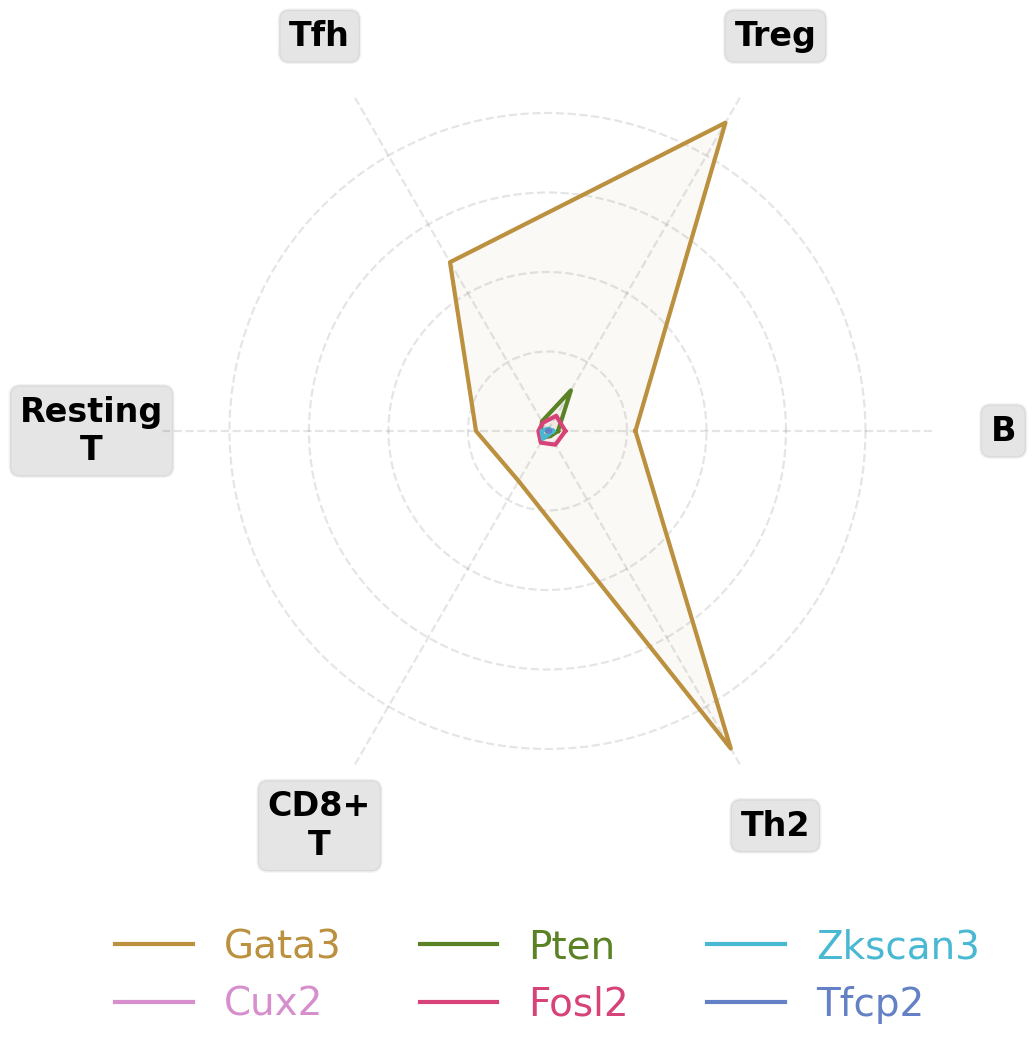

In [68]:
import warnings
warnings.filterwarnings('ignore')

ko_concat_norm = pd.DataFrame(
    # StandardScaler().fit_transform(ko_concat), 
    ko_concat, 
    index=ko_concat.index, 
    columns=ko_concat.columns
)

fig, ax = plt.subplots(1, 1, 
        figsize=(5, 5), dpi=100, 
        subplot_kw={'projection': 'polar'})
colors = ["#7b63d0", "#f70606",
"#c651bb",
"#56b951",
"#9cb835",
"#d74278",
"#57be93",
"#cf4a35",
"#49b9d3",
"#e08830",
"#6481c6",
"#c9a841",
"#9b508b",
"#5b8225",
"#d68ecd",
"#3f7c4a",
"#b85865",
"#7c722c",
"#e49373",
"#9e622e"]


ligands = ['Il2', 'Il15', 'Il4', 'Cxcl13', 'Ccl5', 'Lgals9']
receptors = ['Il2ra', 'Cxcr4', 'Ccr4', 'Il4ra', 'Il6st', 'Cxcr5']
tf = ['Gata3', 'Prdm1', 'Pax5', 'Foxp3', 'Bcl6', 'Stat4']
randoms = ['Gata3', 'Cux2', 'Pten', 'Fosl2', 'Zkscan3', 'Tfcp2']

np.random.shuffle(colors)
colors[0] = "#bb903e"
# colors = ["#bb903e",
# "#8767c9",
# "#69a657",
# "#c75d9e",
# "#619cce",
# "#cb584d"]


for i, col in enumerate(randoms):
    values = ko_concat_norm[col].values.tolist()
    values += values[:1]  # Repeat first value to close polygon
    
    angles = np.linspace(0, 2*np.pi, len(ko_concat_norm.index), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Repeat first angle to close polygon

    ax.plot(angles, values, '-', linewidth=1.5, 
            label=col, 
            color=colors[i]
        )
    ax.fill(angles, values, alpha=0.05, 
        edgecolor='black', 
        color=colors[i], 
        linewidth=0.5, hatch='')
    

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(
        ko_concat_norm.index.str.replace(' ', '\n'), size=12,
        fontweight='bold',
    )

    for t in ax.get_xticklabels():
        txt = t.get_text()
        t.set_color('black')
        t.set_fontweight('bold')
        t.set_bbox(dict(boxstyle="round,pad=0.3", 
            fc='black', 
            ec="gray", alpha=0.1)
        )
    ax.set_rlabel_position(0)
    ax.tick_params(pad=15)

    ax.grid(True, alpha=0.1, linestyle='--', color='black')
    ax.set_yticklabels(labels=ax.get_yticks(), size=5)

    ax.spines['polar'].set_visible(False)
    legend = ax.legend(bbox_to_anchor=(0.5, -0.1), 
        loc='upper center', ncol=3, frameon=False, fontsize=14)
    for text, line in zip(legend.get_texts(), legend.get_lines()):
        text.set_color(line.get_color())
    ax.set_rlabel_position(35)
    ax.set_yticklabels([])

In [70]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_lymph1_visiumHD.h5ad')

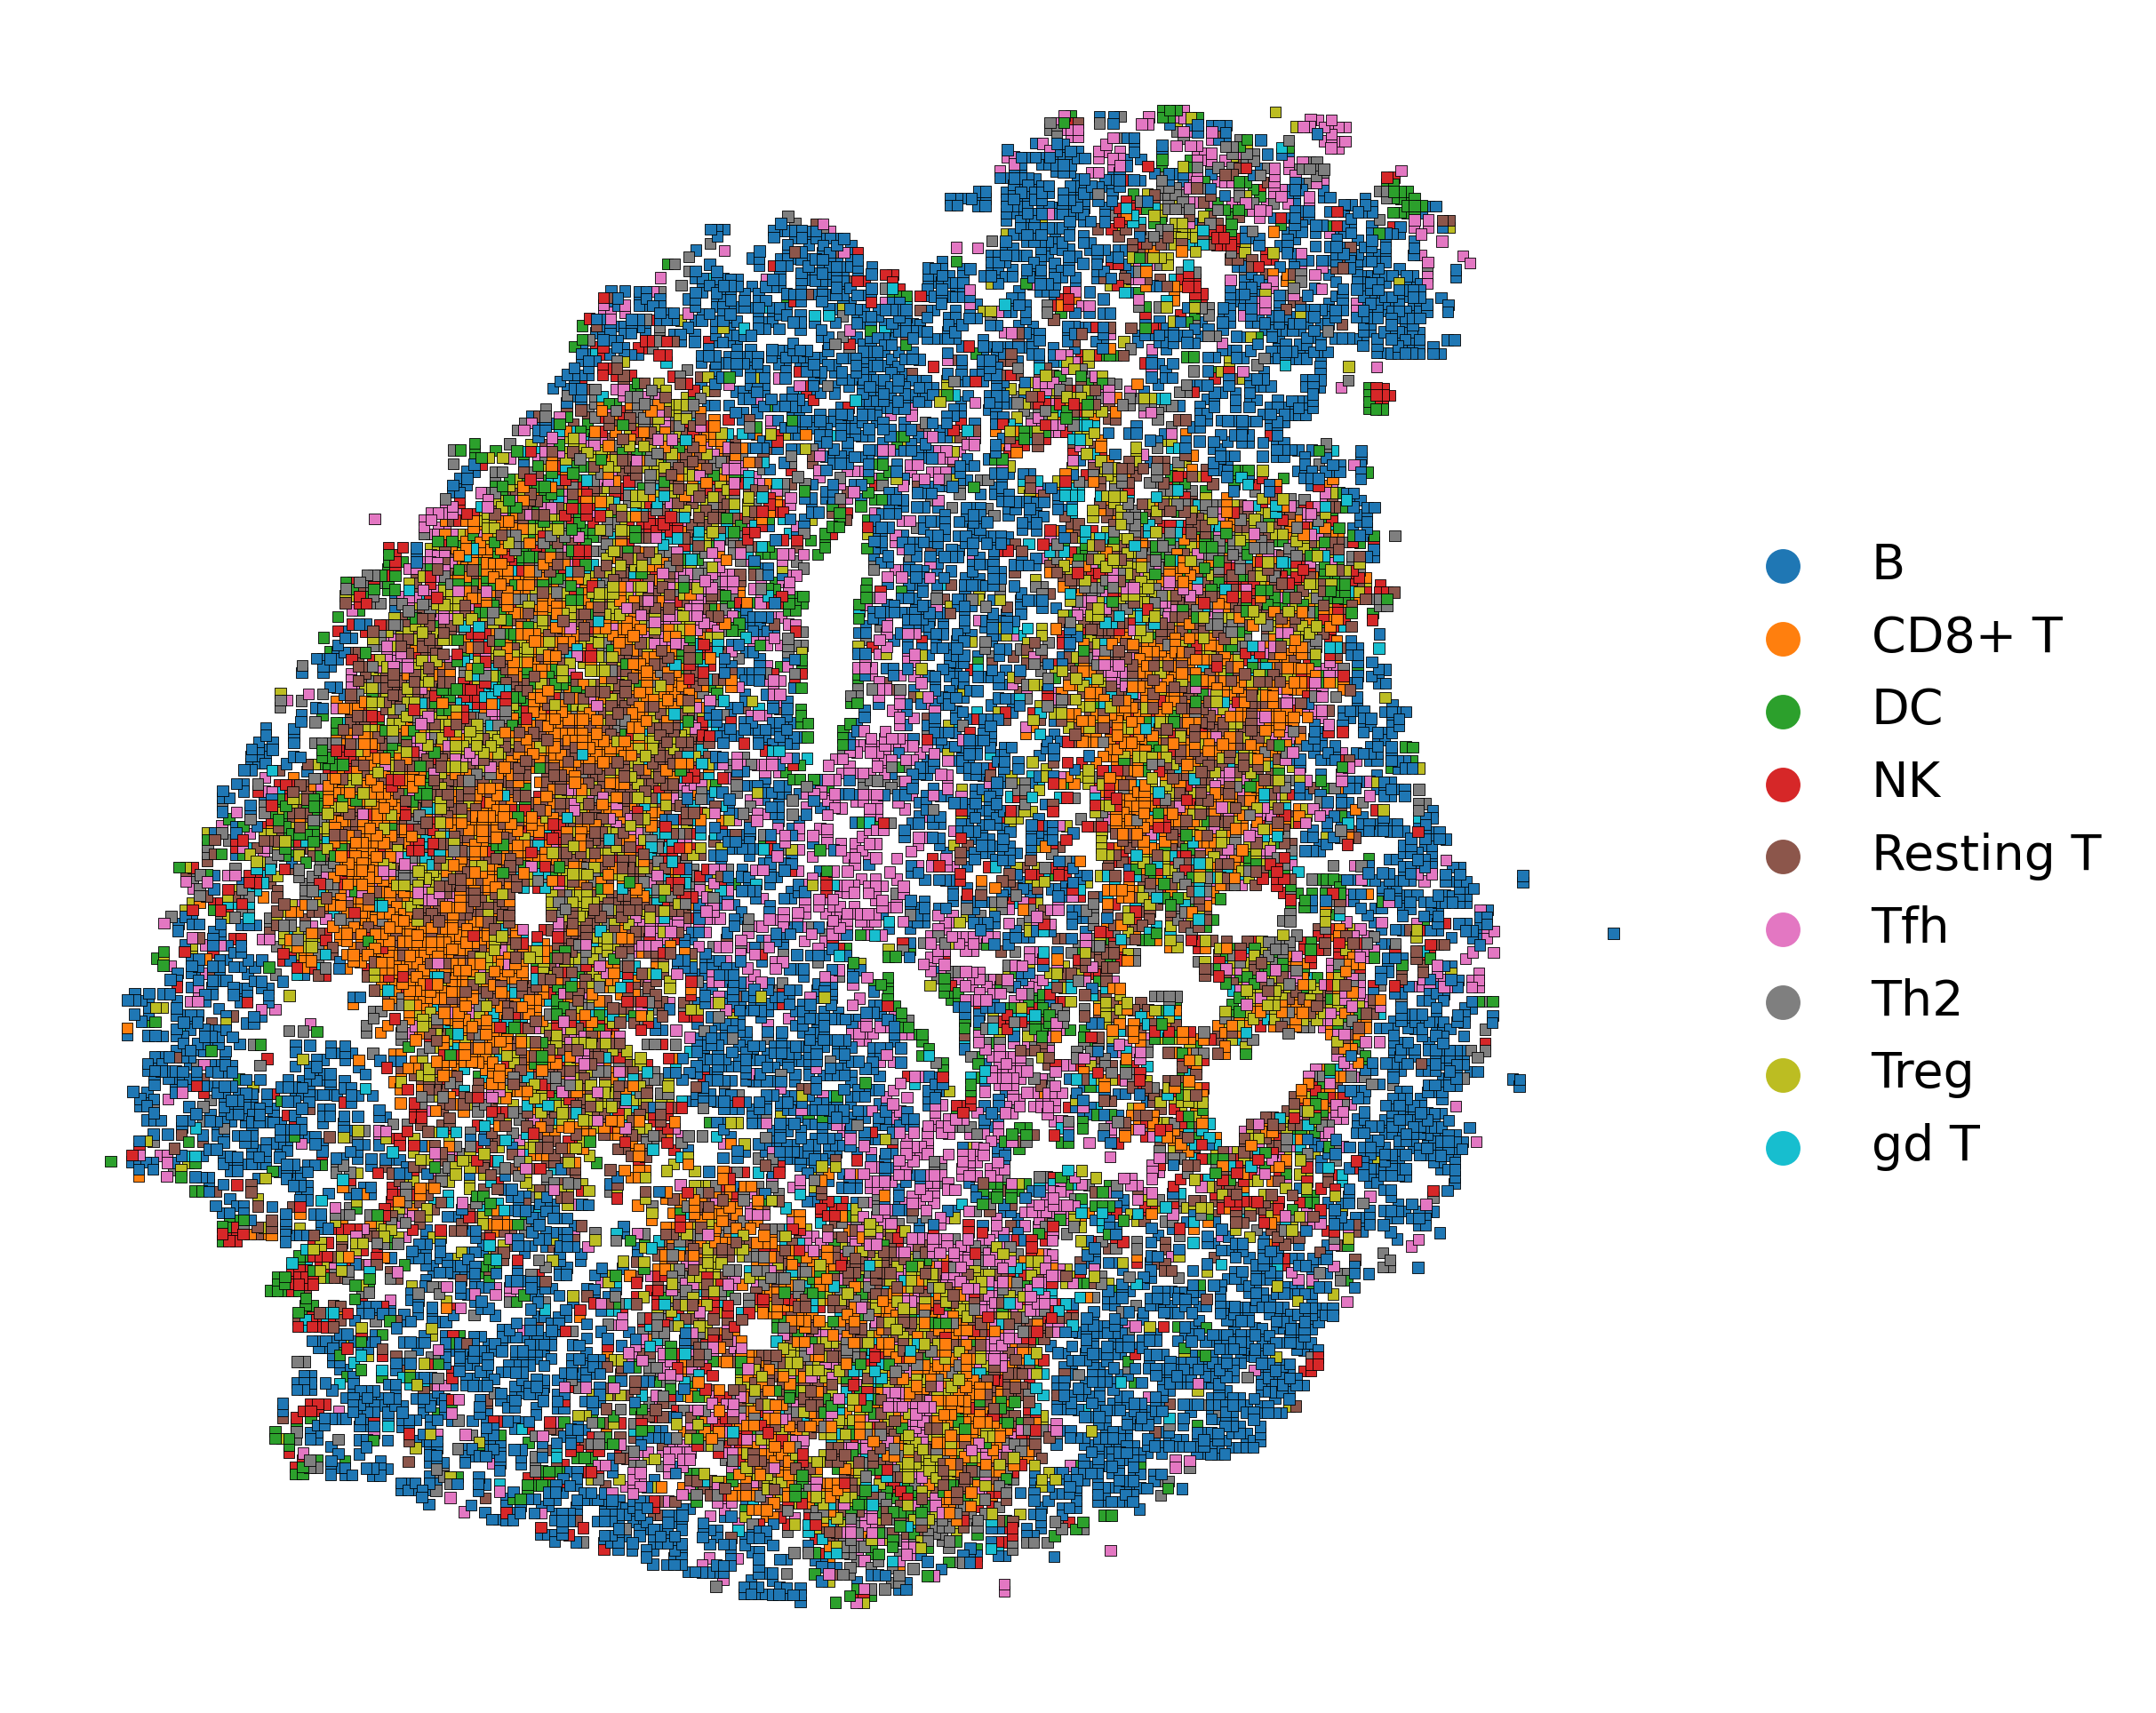

In [107]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 200

sc.pl.embedding(adata, basis='spatial', frameon=False, 
        color='cell_type', marker='s', title='', s=5, 
        palette='tab10', linewidth=0.15, edgecolor='black')

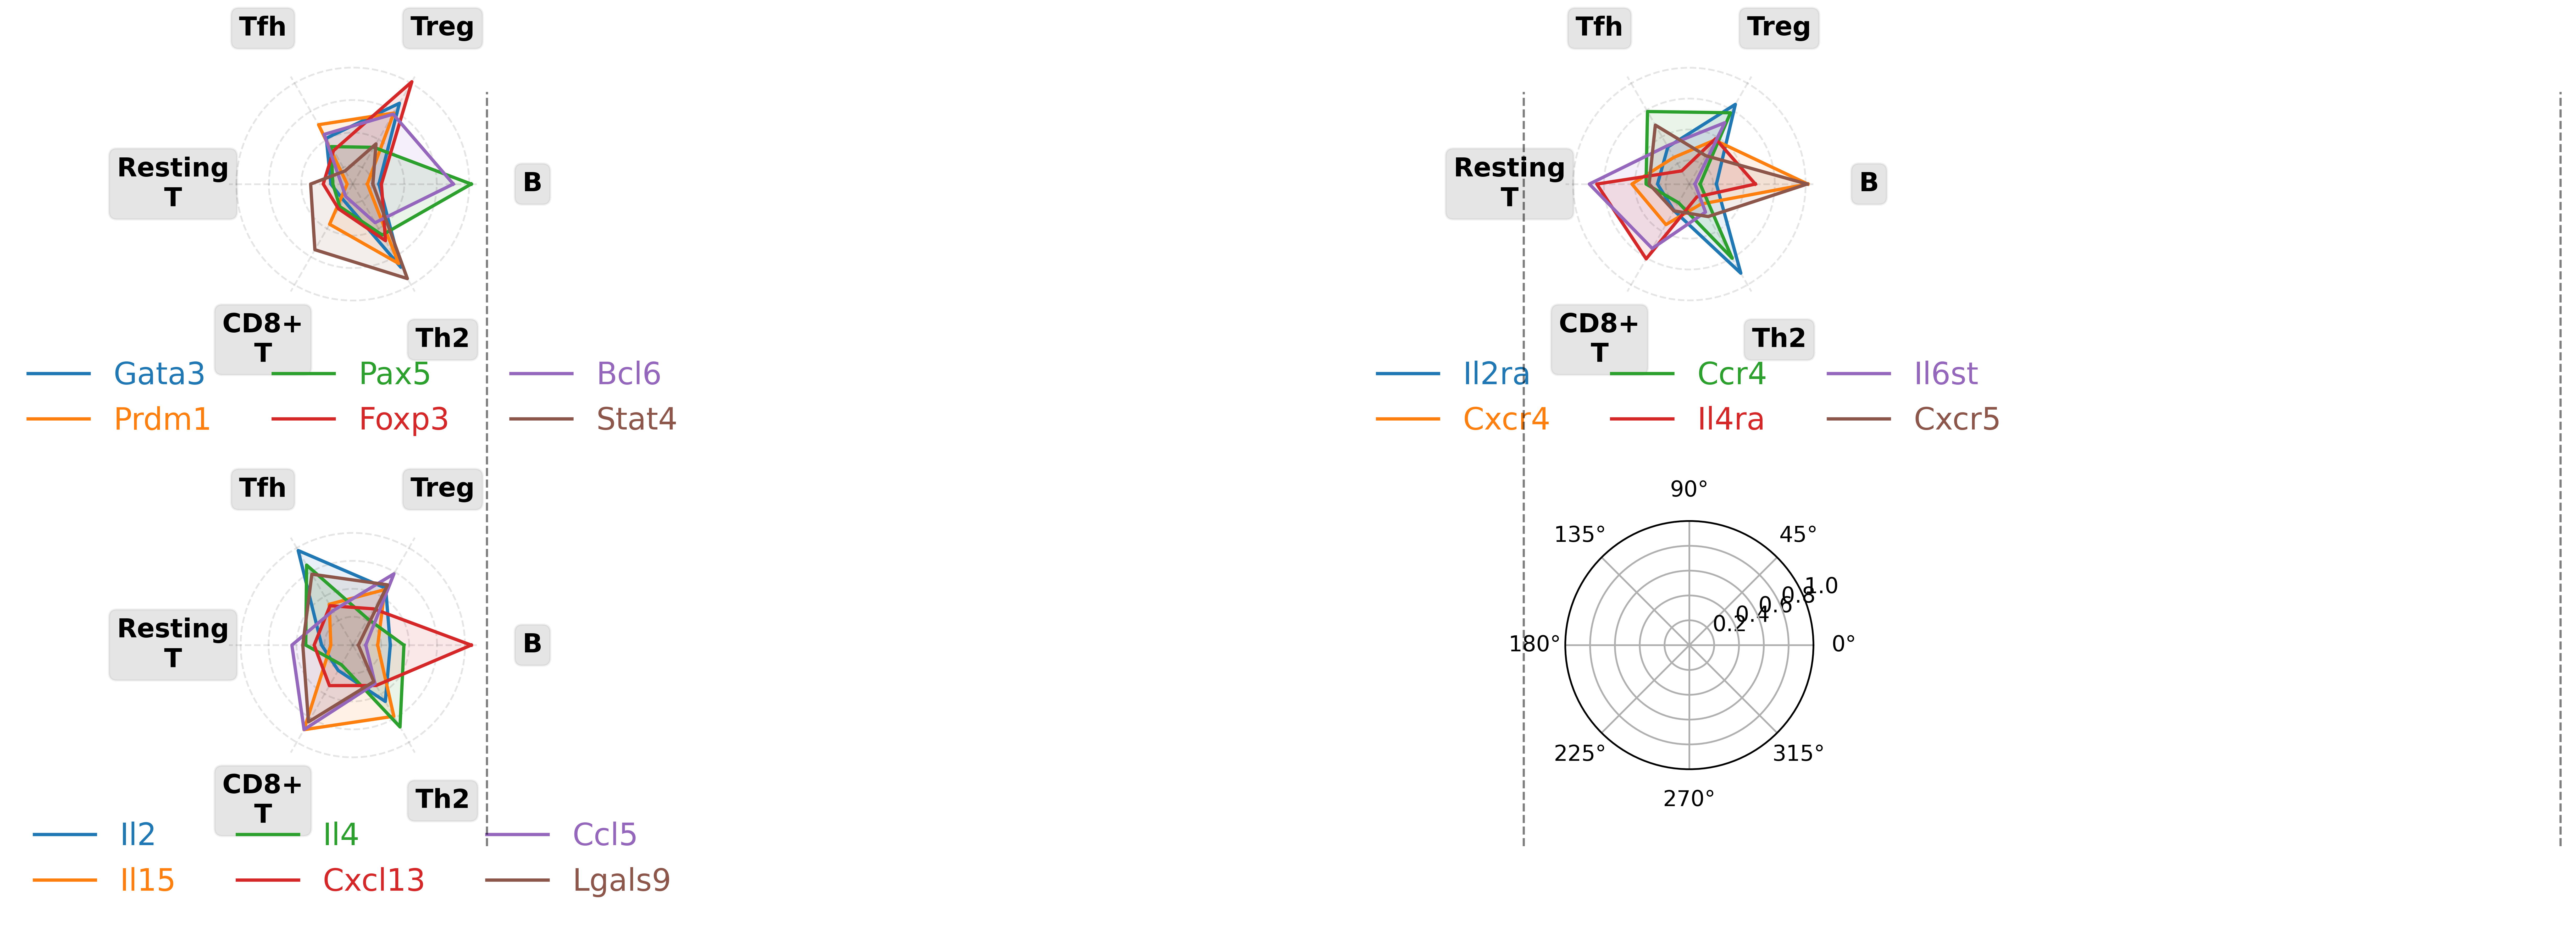

In [39]:
ko_concat_norm = pd.DataFrame(
    StandardScaler().fit_transform(ko_concat), 
    # ko_concat, 
    index=ko_concat.index, 
    columns=ko_concat.columns
)

ligands = ['Il2', 'Il15', 'Il4', 'Cxcl13', 'Ccl5', 'Lgals9']
receptors = ['Il2ra', 'Cxcr4', 'Ccr4', 'Il4ra', 'Il6st', 'Cxcr5']
tf = ['Gata3', 'Prdm1', 'Pax5', 'Foxp3', 'Bcl6', 'Stat4']

fig, axs = plt.subplots(2, 2, 
        figsize=(20, 6), dpi=300, 
        subplot_kw={'projection': 'polar'})
axs = axs.flatten()

for ax, geneset in zip(axs, [tf, receptors, ligands]):
    for i, col in enumerate(geneset):
        values = ko_concat_norm[col].values.tolist()

        values += values[:1]  # Repeat first value to close polygon
        
        angles = np.linspace(0, 2*np.pi, len(ko_concat_norm.index), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))  # Repeat first angle to close polygon

        ax.plot(angles, values, '-', linewidth=1.5, 
                label=col, 
                # color=colors[i]
            )
        ax.fill(angles, values, alpha=0.1, 
            edgecolor='black', 
            # color=colors[i], 
            linewidth=0.5, hatch='')
        

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(
        ko_concat_norm.index.str.replace(' ', '\n'), size=12,
        fontweight='bold',
    )

    for t in ax.get_xticklabels():
        txt = t.get_text()
        t.set_color('black')
        t.set_fontweight('bold')
        t.set_bbox(dict(boxstyle="round,pad=0.3", 
            fc='black', 
            ec="gray", alpha=0.1)
        )
    ax.set_rlabel_position(0)
    ax.tick_params(pad=15)

    ax.grid(True, alpha=0.1, linestyle='--', color='black')
    ax.set_yticklabels(labels=ax.get_yticks(), size=5)

    ax.spines['polar'].set_visible(False)
    legend = ax.legend(bbox_to_anchor=(0.5, -0.1), 
        loc='upper center', ncol=3, frameon=False, fontsize=14)
    for text, line in zip(legend.get_texts(), legend.get_lines()):
        text.set_color(line.get_color())
    ax.set_rlabel_position(35)
    ax.set_yticklabels([])

# Add dividers between subplots
for i in range(1, len(axs)):
    fig.add_artist(plt.Line2D([0.33*i, 0.33*i], [0.1, 0.9], 
                             transform=fig.transFigure, color='black', 
                             linestyle='--', linewidth=1, alpha=0.5))
plt.tight_layout()
plt.show()

In [39]:
# extra = pd.read_csv('banksy_cluster.csv', index_col=0)
# adata.obs = adata.obs.join(extra.banksy_cluster)
# adata.obs['banksy_cluster'] = adata.obs['banksy_cluster'].astype('category')
# adata.obsm['X_umap'] = extra[['0', '1']].values

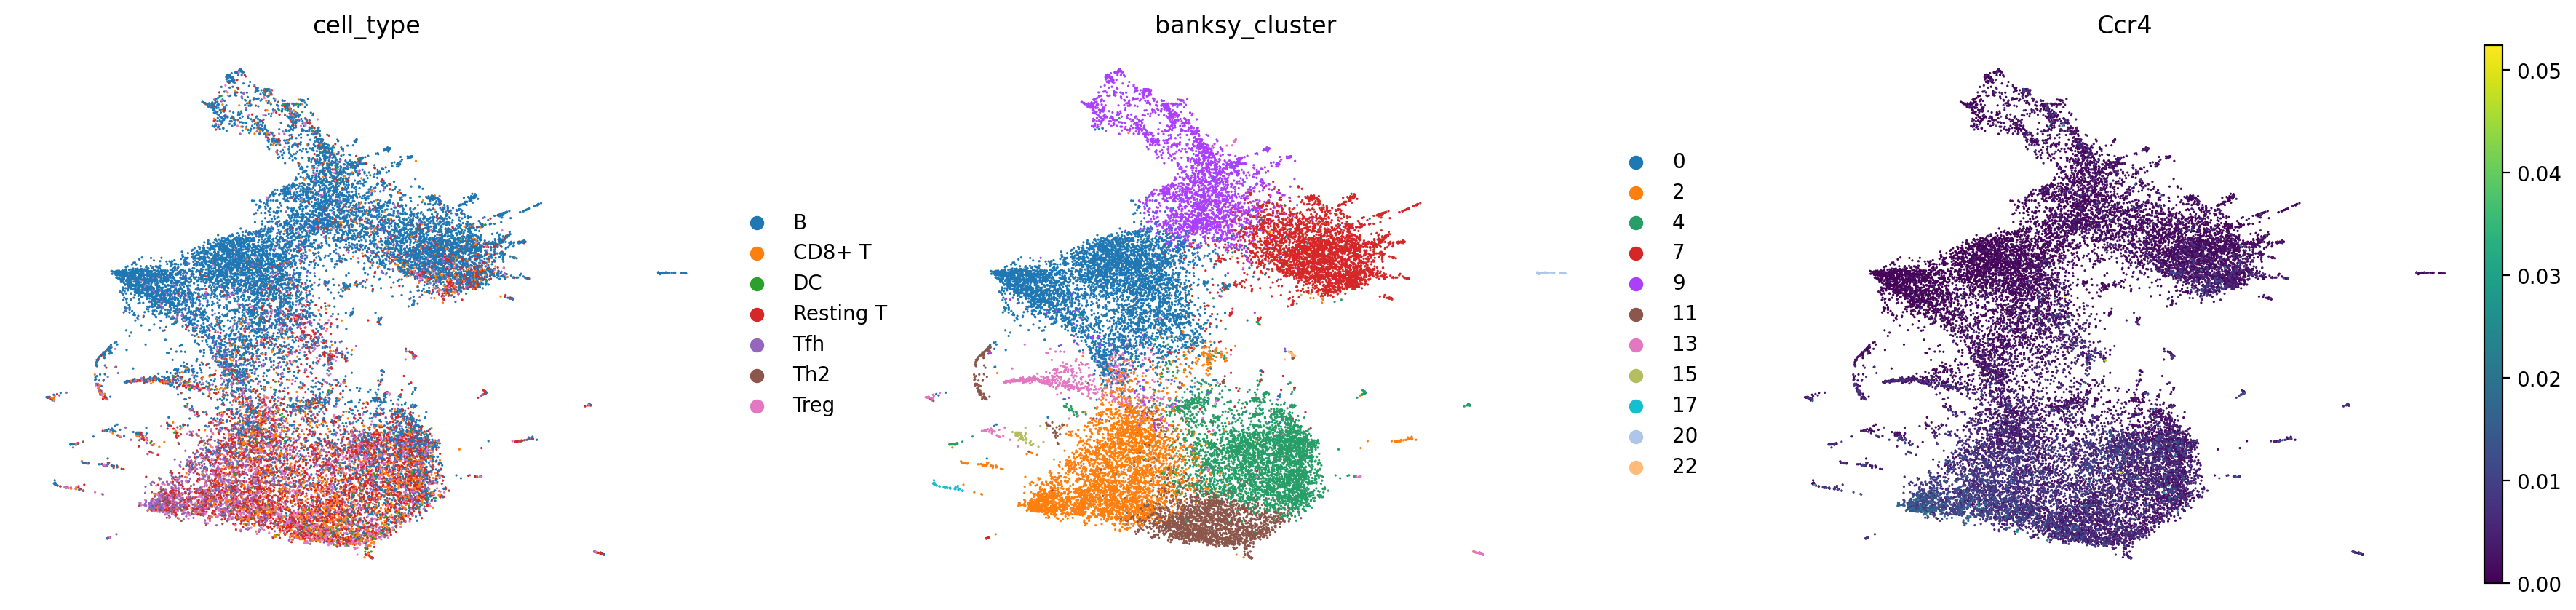

In [60]:
sc.pl.umap(adata, color=['cell_type', 'banksy_cluster', 'Ccr4'], frameon=False, layer='imputed_count')

In [84]:
chart = Cartography(adata[adata.obs.cell_type.isin(['Th2'])], color_dict)

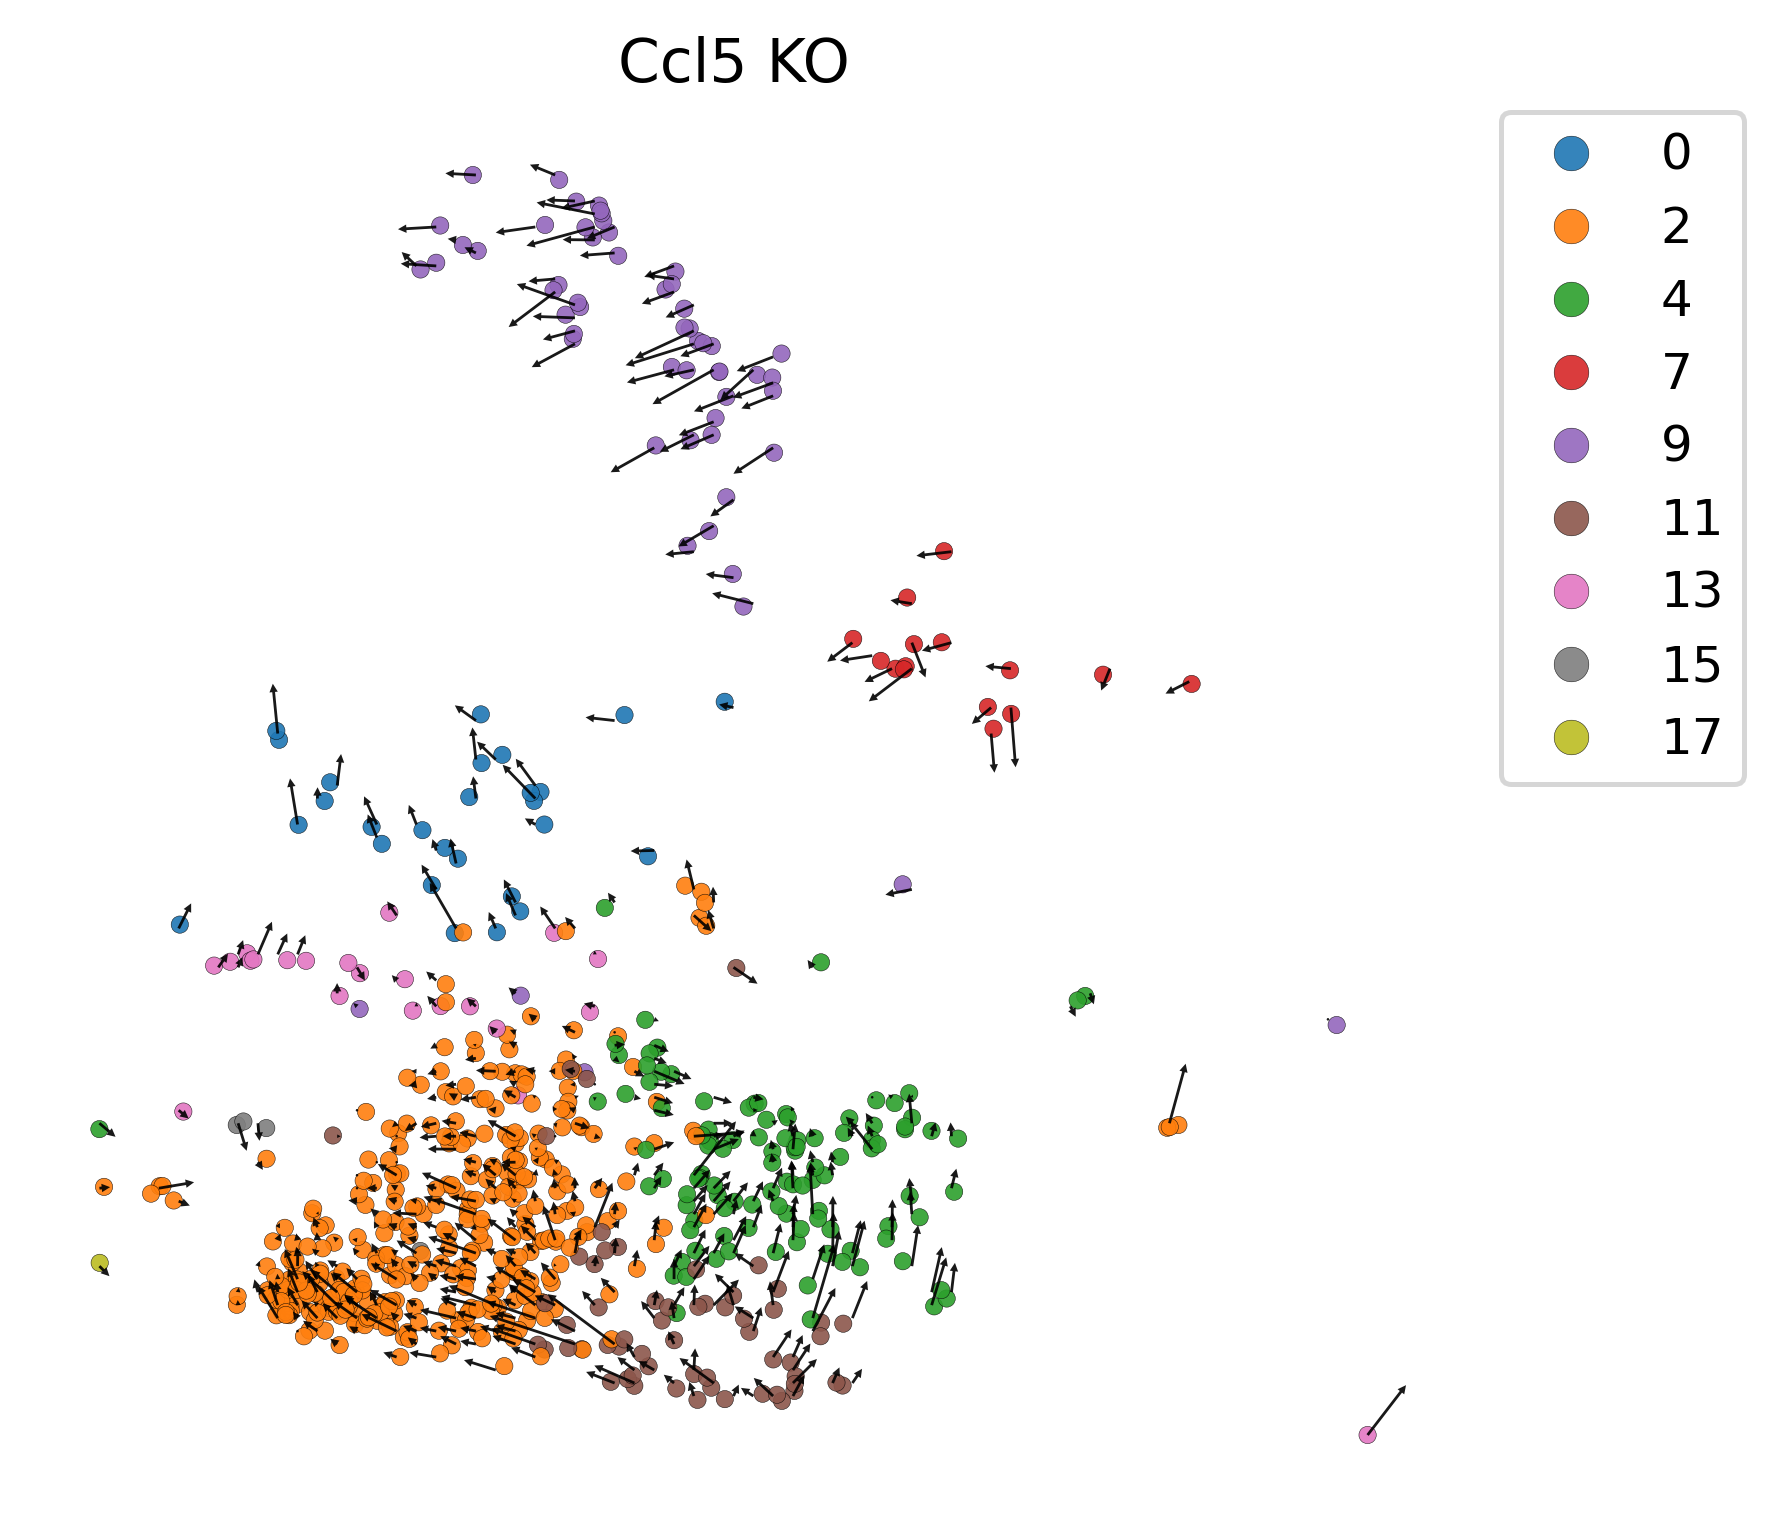

In [85]:
kotarget = 'Ccl5'
perturbed_df = pd.read_parquet(f'/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode/{kotarget}_4n_0x.parquet')
# perturbed_df[kotarget] = adata.to_df(layer='imputed_count')[kotarget]

ax = chart.plot_umap_quiver(
    perturb_target=kotarget,
    grid_scale=2.5,
    vector_scale=0.8,
    figsize=(5, 5), 
    n_neighbors=100,
    hue='banksy_cluster',
    alpha=0.9,
    remove_null=True,
    scatter_size=12,
    perturbed_df=perturbed_df,
    # betadata_path='/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode',
    legend_on_loc=False,
    rescale=1e12
)
plt.title(f'{kotarget} KO')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=2)
plt.show()

In [495]:
from spaceoracle.plotting.shift import estimate_transition_probabilities

embedding = adata.obsm['X_umap']
n_neighbors = 200
kotarget = 'Foxp3'
betadata_path = '/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode'
perturbed_df = pd.read_parquet(
    f'{betadata_path}/{kotarget}_4n_0x.parquet')
delta_X = perturbed_df.loc[
    chart.adata.obs_names].values - chart.adata.layers['imputed_count']
chart.adata.layers[kotarget] = perturbed_df.loc[chart.adata.obs_names].values.copy()
corr = chart.get_corr(kotarget)
P = estimate_transition_probabilities(
    adata, delta_X, embedding, n_neighbors=n_neighbors, n_jobs=1)
del chart.adata.layers[kotarget]

: 

In [122]:
chart.adata.obs

cell_type   author_cell_type cell_type_int leiden leiden_R  \
NAME                                                                            
AAACCCAAGCGCCTTG-1   T cells              T_CD4             7      0      0,0   
AAACCCAAGTGGACGT-1    Plasma             plasma             6      4        1   
AAACCCACAGAAGTGC-1      GC B  B_germinal_center             4      5        2   
AAACCCATCATCGCAA-1  B memory           B_memory             0      7        4   
AAACCCATCCGATCGG-1    Plasma  B_germinal_center             6      4        1   
...                      ...                ...           ...    ...      ...   
TTTGTTGCAGGGACTA-1      GC B  B_germinal_center             4      5        2   
TTTGTTGCATTGTAGC-1    Plasma             plasma             6      4        1   
TTTGTTGGTACCACGC-1      GC B  B_germinal_center             4      5        2   
TTTGTTGGTCTGTCCT-1    CD4+ T              T_CD4             2      2      0,2   
TTTGTTGTCATGCGGC-1    CD4+ T              T_CD4             2      2      0,2   

                   cell_type_2      banksy_celltypes  
NAME                                                  
AAACCCAAGCGCCTTG-1    T memory                 T_CD4  
AAACCCAAGTGGACGT-1      Plasma                plasma  
AAACCCACAGAAGTGC-1        GC B         GC Light Zone  
AAACCCATCATCGCAA-1    B memory              B_memory  
AAACCCATCCGATCGG-1      Plasma  GC Intermediate Zone  
...                        ...                   ...  
TTTGTTGCAGGGACTA-1        GC B          GC Dark Zone  
TTTGTTGCATTGTAGC-1      Plasma                plasma  
TTTGTTGGTACCACGC-1        GC B          GC Dark Zone  
TTTGTTGGTCTGTCCT-1      CD4+ T                 T_CD4  
TTTGTTGTCATGCGGC-1      CD4+ T                 T_CD4  

[5139 rows x 7 columns]

In [70]:
source_ct = 'B_naive'
transition_df = chart.compute_transitions(corr, source_ct=source_ct)

In [71]:
chart.assess_transitions(
    transition_df, 
    base_celltypes=adata.obs.banksy_celltypes, 
    source_ct=source_ct
)

Source Cells: B_naive           min      mean       max
Transition Target                                      
B_naive                3.420945e-10  0.000699  0.001233
B_memory               2.023134e-10  0.000471  0.001060
pDC                    8.469155e-09  0.000053  0.010310
FDC                    4.030107e-10  0.000033  0.002592
T_CD4                  3.030271e-09  0.000030  0.000899
mDC/myeloid            1.258382e-09  0.000025  0.000575
T_CD8                  2.063119e-09  0.000024  0.003378
T_follicular_helper    2.426093e-10  0.000020  0.001501
GC Dark Zone           1.718281e-12  0.000008  0.000361
GC Light Zone          9.751556e-12  0.000007  0.000797
plasma                 8.685132e-12  0.000006  0.000128
GC Intermediate Zone   5.938835e-13  0.000006  0.000480

In [36]:
thresh = 0.00045 # need to cross this to leave base cell phenotype
allowed_fates = [
    # 'T_CD4',
    'plasma',
    'GC Light Zone',
    'B_memory',
    'GC Intermediate Zone',
    # 'T_follicular_helper',
    'GC Dark Zone',
    # 'FDC',
    'B_naive',
    # 'T_CD8',
    # 'mDC/myeloid',
    # 'pDC'
]

transitions = chart.get_cellfate(transition_df, allowed_fates, thresh)

100%|██████████| 274/274 [00:03<00:00, 84.11it/s]

Counter({'B_memory': 184, 'plasma': 70, 'GC Dark Zone': 17, 'B_naive': 2, 'GC Light Zone': 1}) 0.0004521653387598443


In [67]:
projection_params = {
    'basis': 'spatial',
    'color': 'banksy_celltypes', 
    'legend_loc': 'right',
    'recompute': True,
    'stream': False,
    'scale': 0.8,
    'alpha': 0.6,
    'size': 50,
    'show': False,
    'linewidth': 0.1,
    'palette': color_dict,
    'min_mass': 50,
    'smooth': 1.0,
    'edgecolor': 'none',
    'arrow_color':'black',
    'n_neighbors': 100,
}

In [68]:
%%capture
X_grid, V_grid = chart.get_grids(P, projection_params)
vector_field_df = chart.vector_field_df(X_grid, V_grid)


NameError: name 'P' is not defined

In [39]:
import alphashape

In [40]:
source_cells = adata.obs[adata.obs['banksy_celltypes'] == source_ct].index

In [41]:
adata.obs['transition'] = adata.obs['banksy_celltypes'].copy()
adata.obs.loc[source_cells, 'transition'] = np.array(transitions)
ct_points_wt, ct_points_ko = chart.make_celltype_dict()

In [42]:
delta_df = adata.to_df(layer='FOXO1') - adata.to_df(layer='imputed_count')


In [44]:
alpha_shape_1 = alphashape.alphashape(ct_points_wt['GC Light Zone'], alpha=0.04)
alpha_shape_2 = alphashape.alphashape(ct_points_wt['GC Dark Zone'], alpha=0.04)
alpha_shape_3 = alphashape.alphashape(ct_points_wt['GC Intermediate Zone'], alpha=0.04)

In [212]:
# fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
# data = xy.join(adata.obs)
# source_data = data[data.banksy_celltypes == source_ct]
# transition_data = data.loc[source_cells]

# scatter = sns.scatterplot(
#     data=xy.join(adata.obs),
#     x='x', y='y',
#     # hue='banksy_celltypes', 
#     color='grey',
#     s=30,
#     alpha=0.3,
#     edgecolor='none',
#     # palette=color_dict,
#     ax=ax,
# )

# alpha_shape_1 = alphashape.alphashape(ct_points_ko['GC Light Zone'], alpha=0.04)
# alpha_shape_2 = alphashape.alphashape(ct_points_ko['GC Dark Zone'], alpha=0.04)
# alpha_shape_3 = alphashape.alphashape(ct_points_ko['GC Intermediate Zone'], alpha=0.04)

# zone_alpha = 0.85
# for geom in alpha_shape_1.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Light Zone'], alpha=zone_alpha)
        

# for geom in alpha_shape_2.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Dark Zone'], alpha=zone_alpha)

# for geom in alpha_shape_3.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Intermediate Zone'], alpha=zone_alpha)

# alpha_shape_4 = alphashape.alphashape(
#     np.concatenate(
#         [ct_points_wt['GC Light Zone'], 
#          ct_points_wt['GC Intermediate Zone'], 
#          ct_points_wt['GC Dark Zone']]
#         ), alpha=0.03)

# for geom in alpha_shape_4.geoms:
#     if geom.area > 10000:
#         ax.plot(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color='black', alpha=zone_alpha)

# ax.set_frame_on(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_aspect('equal')
# ax.set_xlim(data.x.min() - 10, data.x.max() + 10)
# ax.set_ylim(data.y.min() - 10, data.y.max() + 10)
# plt.show()